# RaJoLink workflow demo based on Python Script Modules for LBD Text Mining Analysis

RaJoLink is a method developed for **open** literature-based discovery (LBD). In contrast to Swanson's `ABC` model, RaJoLink focuses on a semi-automatic identification of candidates ($a$) that could be related to an investigated phenomenon ($c$). This selection is based on the identification of **rare terms** from the literature on $c$. At the heart of the RaJoLink strategy is the rational, unavoidable assumption that if literatures of multiple rare terms share a term in common, then that term becomes a candidate for term $a$.

The **RaJoLink** method comprises three main steps: **Ra**, **Jo**, and **Link**, which focus on rare terms, joint terms and linking terms, respectively. The Ra step searches the literature on phenomenon $C$ for unique or rare terms. The Jo step reviews articles related to these rare terms, and identifies joint terms (candidates for $a$) that appear in them, suggesting the hypothesis that $C$ is related to $A$. The Link step then looks for $b$-terms that bridge the literature on a selected $a$-term and $c$-term; $b$-terms are the candidates that can potentially explain the link.

The identification of rare terms in the Ra step is based on the statistical principle of outliers. Just as outliers in data can lead to significant discoveries, rare terms in the literature can pave the way for innovative connections. A term is considered rare if it occurs in $n$ or fewer data sets, where $n$ is adjustable depending on the experiment or context.

While Swanson's ABC model connects two disjoint literatures with term $b$, RaJoLink uses rare terms to generate term $a$, which bridges the literature with selected rare terms.

Note that in this particular implementation, the search for b-terms is limited to the [MeSH](https://www.nlm.nih.gov/mesh/meshhome.html) words for Enzymes and Coenzymes [D08] and Amino Acids, Peptides, and Proteins [D12], as selected by the domain expert.



Hyperparameters for training the model follow the same pattern as Word2Vec. FastText supports the following parameters from the original word2vec:

- model: Training architecture. Allowed values: `cbow`, `skipgram` (Default `cbow`)
- vector_size: Dimensionality of vector embeddings to be learnt (Default 100)
- alpha: Initial learning rate (Default 0.025)
- window: Context window size (Default 5)
- min_count: Ignore words with number of occurrences below this (Default 5)
- loss: Training objective. Allowed values: `ns`, `hs`, `softmax` (Default `ns`)
- sample: Threshold for downsampling higher-frequency words (Default 0.001)
- negative: Number of negative words to sample, for `ns` (Default 5)
- epochs: Number of epochs (Default 5)
- sorted_vocab: Sort vocab by descending frequency (Default 1)
- threads: Number of threads to use (Default 12)


In addition, fastText has three additional parameters:

- min_n: min length of char ngrams (Default 3)
- max_n: max length of char ngrams (Default 6)
- bucket: number of buckets used for hashing ngrams (Default 2000000)

Import LBD components from the framework notebooks. The purpose of the **import_ipynb** library is to enable the direct import of Jupyter Notebooks as modules, allowing code, functions, and classes defined in a notebook to be easily reused in other notebooks or python scripts.

In [3]:
import logging

# Initialize logging with a basic configuration
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s: %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# logging.debug('This is a debug message')
# logging.info('This is an info message')
# logging.warning('This is a warning message')
# logging.error('This is an error message')
# logging.critical('This is a critical message')

In [4]:
import import_ipynb
import LBD_01_data_acquisition
import LBD_02_data_preprocessing
import LBD_03_feature_extraction
import LBD_04_text_mining
import LBD_05_results_analysis
import LBD_06_visualization

Import additional python libraries.

In [19]:
import nltk
import numpy as np
import itertools
import pandas as pd
# import pickle
# import json
import spacy
from typing import List, Dict

In [20]:
# Uncomment just for the first time download of en_core_web_md
#!python -m spacy download en_core_web_md 

nlpr = spacy.load("en_core_web_md")


# Step Ra

In [5]:
# converting file to ascii helper
# LBD_01_data_acquisition.convert_file_to_ascii_encoding('input/214Texts.txt', 'input/214Texts_1.txt')

Define the name of the domain $C$ and load the responding text from the file. The expected file format is as follows:

1. The file is encoded in ascii or utf-8 standard.
2. Each line in the file represents one document. The words in each document are separated by spaces. Each document has a different length.
3. The first word in each line is the **unique id**, followed by a semicolon. Normally **pmid** (pubmed id) can be used for this purpose.
4. The second word in each line can optionally stand for a predefined domain (or class) of the document. In this case, the second word is preceded by **!**. For example, if the file contains documents that originate from two domains, e.g. *migraine* and *magnesium*, the second word in each line is either **!migraine** or **!magnesium**.
5. If the second word is not preceded by **!**, it is considered the first word of the document. In this case, the **!NA** (**not applicable** or **not available**) domain is assigned to the document.

In [6]:
domainName = 'Autism'
fileName = 'input/214Texts.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
# display the first 7 lines of the document
lines[:7]

2024-06-21 10:56:24: INFO - Loaded 214 lines from "input/214Texts.txt".


['16911972: Assessing young children can be difficult, particularly when one considers the type of test behavior required for a psychological evaluation (Culbertson & Willis, 1993). Young children who are referred for a developmental evaluation because they appear to have features of autism can be particularly challenging, given their limited social interaction and communication skills (Marcus, Lansing, & Schopler, 1993; National Research Council, 2001). Many features and behavior problems can further interfere with the accurate assessment of a young child?s cognitive abilities, including difficulty maintaining attention, overactivity, sensory issues, and poor compliance, particularly in an unfamiliar setting. Young children with autism can be easily frustrated, and may not appear ?eager to please? due to their social difficulties or limited understanding of what is being asked of them. It is critical to identify cognitive strengths and weaknesses and developmental delays in the young 

In [ ]:
# remove before publishing
domainName = 'Demo'
fileName = 'input/demo_2.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

In [ ]:
# for testing purposes - remove later
lines = LBD_01_data_acquisition.load_data_from_file("input/Migraine_before1988.txt")
lines[:7]

In [ ]:
# remove before publishing
# plato's dialogues
lines = LBD_01_data_acquisition.load_data_from_file("input/plato_dialogues_ontogen.txt")
lines[:7]

Load and preprocess MESH words for Enzymes and Coenzymes [D08] and Amino Acids, Peptides, and Proteins [D12]. The input file MESH_D08_D12.txt after the preprocessing contains 3534 words that are used in further preprocessing of autism files.

In [7]:
mesh_lines = LBD_01_data_acquisition.load_data_from_file("input/MESH_D08_D12.txt")

mesh_docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(mesh_lines)

keep_list = []
remove_list = []
mesh_prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    mesh_docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = [], \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 5, keep_only_nouns = False, keep_only_mesh = False, stemming = False, stem_type = None)

mesh_prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(mesh_prep_docs_dict)

mesh_word_list, mesh_bow_matrix = LBD_03_feature_extraction.create_bag_of_words(mesh_prep_docs_list, 1, 1)
print('Number of terms in MESH D08 and D12 vocabulary: ', len(mesh_word_list))

print(mesh_word_list.index('lactoylglutathione'))
print(mesh_word_list.index('calcium'))
print(mesh_word_list.index('channel'))
print(mesh_word_list.index('synaptophysin'))



2024-06-21 10:56:28: INFO - Loaded 1 lines from "input/MESH_D08_D12.txt".
2024-06-21 10:56:28: INFO - Text cleaning ...
2024-06-21 10:56:28: INFO - Removing stopwords ...
2024-06-21 10:56:28: INFO - Lematization ...
2024-06-21 10:56:29: INFO - Keeping only longer words ...
2024-06-21 10:56:29: INFO - Preprocessing finished.


Number of terms in MESH D08 and D12 vocabulary:  3534
1984
624
750
3216


Preprocess documents into a dictionary and extract documents as strings in a list.

In [8]:
docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(lines)

keep_list = []
remove_list = []
prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = mesh_word_list, \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 5, keep_only_nouns = True, keep_only_mesh = True, stemming = False, stem_type = None)

ids_list = LBD_02_data_preprocessing.extract_ids_list(prep_docs_dict)
prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(prep_docs_dict)

2024-06-21 10:56:32: INFO - Text cleaning ...
2024-06-21 10:56:33: INFO - Removing stopwords ...
2024-06-21 10:56:33: INFO - Lematization ...
2024-06-21 10:56:34: INFO - Keeping only longer words ...
2024-06-21 10:56:34: INFO - Keeping only nouns ...
2024-06-21 10:57:05: INFO - Keeping only selected MeSH terms ...
2024-06-21 10:57:10: INFO - Preprocessing finished.


Display the first dictionary items, document (pubmed) ids and preprocessed documents.

In [9]:
dict(itertools.islice(prep_docs_dict.items(), 7))

{'16911972': {'domain': 'NA',
  'document': 'Assessing young children can be difficult, particularly when one considers the type of test behavior required for a psychological evaluation (Culbertson & Willis, 1993). Young children who are referred for a developmental evaluation because they appear to have features of autism can be particularly challenging, given their limited social interaction and communication skills (Marcus, Lansing, & Schopler, 1993; National Research Council, 2001). Many features and behavior problems can further interfere with the accurate assessment of a young child?s cognitive abilities, including difficulty maintaining attention, overactivity, sensory issues, and poor compliance, particularly in an unfamiliar setting. Young children with autism can be easily frustrated, and may not appear ?eager to please? due to their social difficulties or limited understanding of what is being asked of them. It is critical to identify cognitive strengths and weaknesses and d

In [10]:
ids_list[:7]

['16911972',
 '16835068',
 '16816240',
 '16770606',
 '16722615',
 '16709250',
 '16703115']

In [11]:
prep_docs_list[:7]

['interaction delay disorder information disorder disorder disorder pattern disorder alternative motor motor delay group group group group group initiation group brain motor group disorder group group group motor group group group group group group group group group group group group group group group delay delay werner activity block function program function group group delay delay disorder design motor combination motor motor response sense function',
 'disorder interaction period disorder disorder syndrome disorder disorder retardation sclerosis syndrome gastrointestinal disorder factor disorder factor associate brain brain information factor cytokine lymphocyte activation neuropeptides family family disorder disorder sclerosis syndrome syndrome syndrome syndrome regions disease replication interaction syndrome regions sclerosis group sclerosis factor origin brain growth growth brain regions factor origin pregnancy influenza pregnancy neural animal herpes component factor light del

Generate bag-of-words matrix from the list of preprocessed documents. Remove n-gram words that occur less than *min_ngram_count* times (3 in our case) in the whole corpus of documents. Remove also the words that are not pressent in the MESH list *mesh_word_list*.

In [12]:
ngram_size = 2
min_df = 1

# BOW representation
word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all n-grams: ', len(word_list))
# print(word_list)
# print(bow_matrix)

# remove nterms with frequency count less than min_count_ngram from vocabulary word_list and bow_matrix
min_count_ngram = 3
tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

tmp_filter_columns = []
for i, word in enumerate(word_list):
    if not LBD_03_feature_extraction.word_is_nterm(word):
        if word in mesh_word_list:
            tmp_filter_columns.append(i)
    else:
        if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
            check_ngram = word.split()
            passed = True
            for check_word in check_ngram:
                if check_word not in mesh_word_list:
                    passed = False
            if check_ngram[0] == check_ngram[1]:
                passed = False
            # passed = True
            if passed:
                tmp_filter_columns.append(i)

tmp_filter_rows = []
for i, id in enumerate(ids_list):
    tmp_filter_rows.append(i)

tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
bow_matrix = tmp_filtered_bow_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent n-grams and non MESH words: ', len(word_list))

LBD_02_data_preprocessing.save_list_to_file(word_list, "output/_list.txt")
LBD_02_data_preprocessing.save_list_to_file(prep_docs_list, "output/_prep_list.txt")


Number of terms in initial vocabulary with all n-grams:  9152
Number of terms in preprocessed vocabulary after removing infrequent n-grams and non MESH words:  2354


Compute margins for bag-of-word matrix. Prepare also the dictionaries of words and documents sorted according to the sum of word count in BOW matrix (*bow_matrix*).

In [13]:
sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)

print('Number of documents in which each word is present: ', dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
print('Number of occurences of each word in all documents: ', dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
print('Number of words in each document: ', dict(itertools.islice(sum_count_words_in_doc.items(), 7)))

# Compute the order of rows (documents) and columns (words) in the bow matrix so that the most frequent words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list) 

# Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, bow_matrix, filter_rows, filter_columns)
print('The first few documents in the rows of the filtered bow matrix: ', filtered_ids_list[:7])
print('The first few words in the columns of the filtered bow matrix: ', filtered_word_list[:7])

Number of documents in which each word is present:  {'acceptor': 2, 'acceptor splice': 1, 'accessory': 1, 'acetate': 3, 'acetylcholine': 1, 'acetylcholinesterase': 1, 'acids': 16}
Number of occurences of each word in all documents:  {'acceptor': 4, 'acceptor splice': 3, 'accessory': 1, 'acetate': 4, 'acetylcholine': 2, 'acetylcholinesterase': 1, 'acids': 34}
Number of words in each document:  {'16911972': 91, '16835068': 296, '16816240': 72, '16770606': 212, '16722615': 302, '16709250': 354, '16703115': 231}
The first few documents in the rows of the filtered bow matrix:  ['10727395', '16262991', '16262984', '15138176', '16467917', '16251272', '15492925']
The first few words in the columns of the filtered bow matrix:  ['group', 'disorder', 'response', 'function', 'sequence', 'brain', 'region']


Visualize bag-of-words matrix.

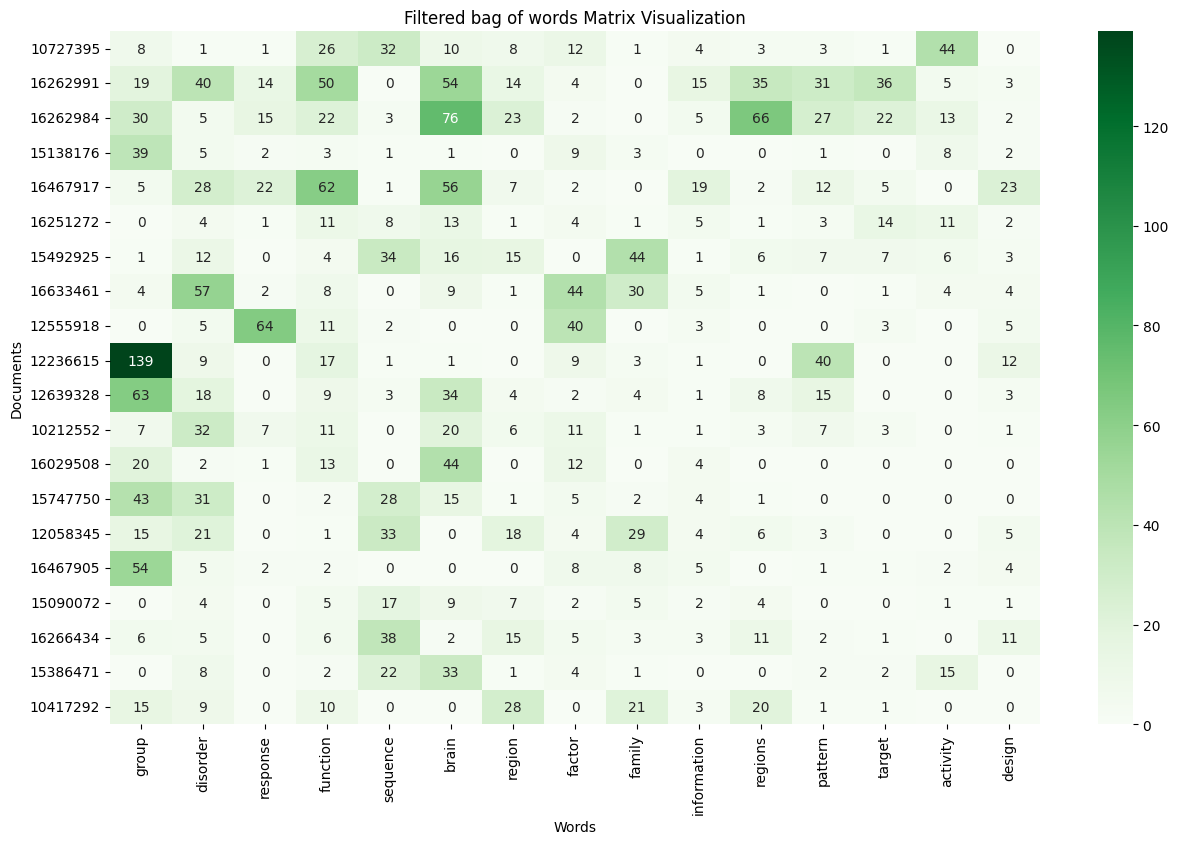

In [14]:
first_row = 0
last_row = 20
first_column = 0
last_column = 15
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered bag of words', \
                                           filtered_bow_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], \
                                           filtered_word_list[first_column:last_column], as_int = True)

Generate tf-idf matrix from the list of preprocessed documents.

In [15]:
# TF-IDF representation
word_list, tfidf_matrix = LBD_03_feature_extraction.create_tfidf(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all n-grams: ', len(word_list))
# print(word_list)
# print(tfidf_matrix)

# Rearange (filter) the tfidf matrix according to the previously computed order from bow matrix.
tmp_filtered_word_list, tmp_filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, tfidf_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
tfidf_matrix = tmp_filtered_tfidf_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent n-grams and non MESH words: ', len(word_list))

Number of terms in initial vocabulary with all n-grams:  9152
Number of terms in preprocessed vocabulary after removing infrequent n-grams and non MESH words:  2354


Compute margins for tf-idf matrix.

In [16]:
sum_word_tfidf = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, tfidf_matrix)
max_word_tfidf = LBD_03_feature_extraction.max_tfidf_each_word_in_all_documents(word_list, tfidf_matrix)

sum_doc_tfidf = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, tfidf_matrix)
max_doc_tfidf = LBD_03_feature_extraction.max_tfidf_all_words_in_each_document(ids_list, tfidf_matrix)

print('Sum of tfidf for each word: ', dict(itertools.islice(sum_word_tfidf.items(), 7)))
print('Max of tfidf for each word: ', dict(itertools.islice(max_word_tfidf.items(), 7)))

print('Sum of tfidf for each document: ', dict(itertools.islice(sum_doc_tfidf.items(), 7)))
print('Max of tfidf for each document: ', dict(itertools.islice(max_doc_tfidf.items(), 7)))

# Compute the order of rows (documents) and columns (words) in the tfidf matrix so that the most important words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_doc_tfidf, reverse=True), ids_list) 

# Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, tfidf_matrix, filter_rows, filter_columns)

Sum of tfidf for each word:  {'acceptor': 0.09729477522261587, 'acceptor splice': 0.092547732720337, 'accessory': 0.0275101018064679, 'acetate': 0.2101499239729437, 'acetylcholine': 0.11398916448036536, 'acetylcholinesterase': 0.08029993715223485, 'acids': 0.8631005089612098}
Max of tfidf for each word:  {'acceptor': 0.08593832066488775, 'acceptor splice': 0.092547732720337, 'accessory': 0.0275101018064679, 'acetate': 0.11197077589695603, 'acetylcholine': 0.11398916448036536, 'acetylcholinesterase': 0.08029993715223485, 'acids': 0.17334906364752192}
Sum of tfidf for each document:  {'16911972': 3.0365380713574357, '16835068': 8.279716494952641, '16816240': 4.693553738081428, '16770606': 6.581739814959549, '16722615': 5.9042067043378665, '16709250': 8.770184291214916, '16703115': 3.7564971568311094}
Max of tfidf for each document:  {'16911972': 0.5772598313269415, '16835068': 0.2654008284321545, '16816240': 0.4286792954262982, '16770606': 0.4076253752876625, '16722615': 0.60171415155480

Visualize tf-idf matrix.

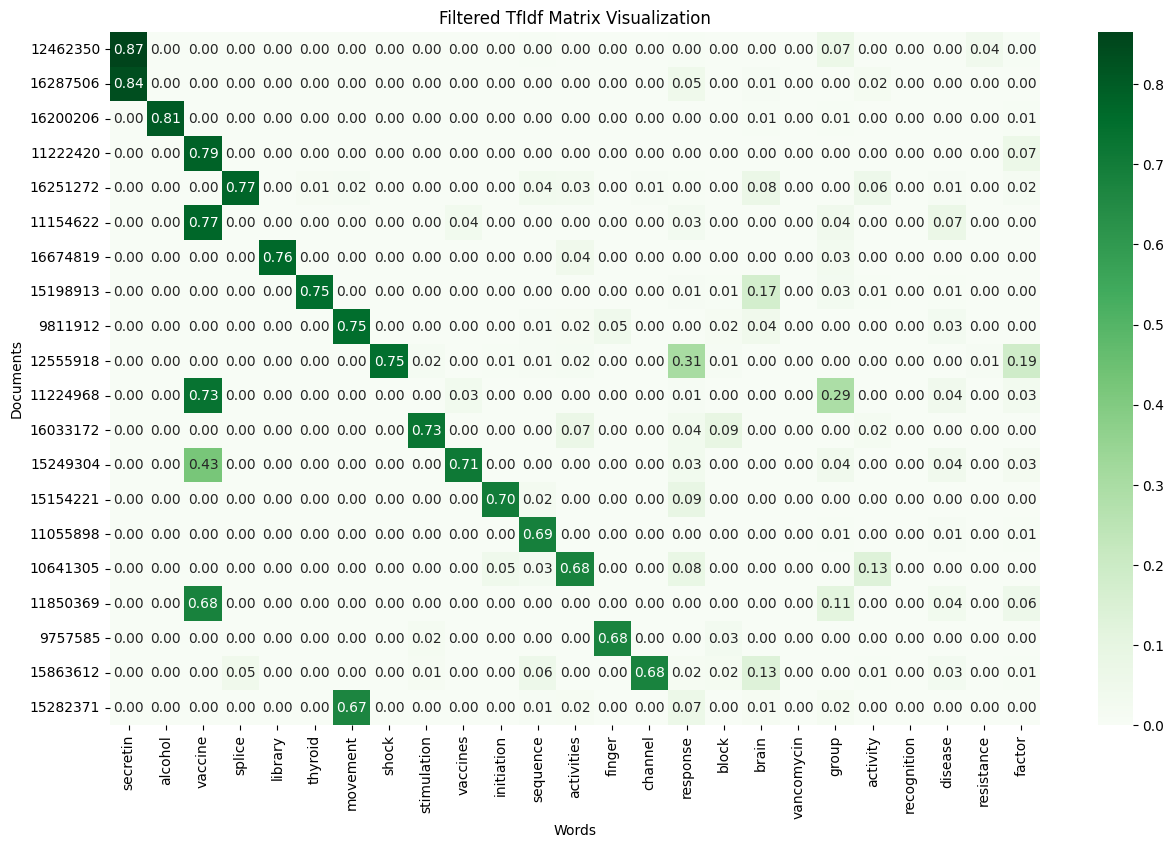

In [17]:
first_row = 0
last_row = 20
first_column = 0
last_column = 25
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered TfIdf', filtered_tfidf_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], filtered_word_list[first_column:last_column], as_int = False)

Generate a list of the domain names of all the documents and a list of unique domain names.

In [18]:
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(docs_dict)
print('Domain names for the first few documents: ', domains_list[:7])
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
print('A list of all uniques domain names in all the documents: ', unique_domains_list)


Domain names for the first few documents:  ['NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']
A list of all uniques domain names in all the documents:  ['NA']


Visualize the documents in 2D graph by reducing the dimensionality of tfidf matrix with PCA.

In [19]:
LBD_06_visualization.visualize_tfidf_pca_interactive(ids_list, domains_list, tfidf_matrix, transpose = False)

In [20]:
from sklearn.cluster import KMeans

# Cluster the documents using KMeans
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(tfidf_matrix)
cluster_assignments = list(np.asarray(kmeans.labels_))
cluster_assignments = [str(i) for i in cluster_assignments]
type(cluster_assignments)

c:\Work\bc3\venv\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



list

In [21]:
LBD_06_visualization.visualize_tfidf_pca_interactive(ids_list, cluster_assignments, tfidf_matrix, transpose = False)

In [22]:
domains_list = [LBD_02_data_preprocessing.strDomainDefault]*len(word_list)
LBD_06_visualization.visualize_tfidf_pca_interactive(word_list, domains_list, tfidf_matrix, transpose = True)

Generate a list of *rare* words. Use the max value of word tf-idf for sorting the list of rare words.

TODO: describe the criterion for rare term selection

In [ ]:
print("Dictionary of words, count and max(tfidf):")

max_word_tfidf_selected = {}
for word in max_word_tfidf.keys():
    if sum_count_docs_containing_word[word] <= 1:
        max_word_tfidf_selected[word] = max_word_tfidf[word]
         
import itertools
print('All the words in vocabulary: ', len(max_word_tfidf))
print('Selected rare words: ', len(max_word_tfidf_selected), ' ', dict(itertools.islice(max_word_tfidf_selected.items(), 30)))

max_word_tfidf_selected_sorted = LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf_selected, True)

print('Sorted rare words: ', len(max_word_tfidf_selected_sorted), ' ', dict(itertools.islice(max_word_tfidf_selected_sorted.items(), 30)))
print('First and last sorted rare word: ', list(max_word_tfidf_selected_sorted.items())[0], ' ', list(max_word_tfidf_selected_sorted.items())[-1])
print('Mean value of max tfidf values: ', np.array(list(max_word_tfidf_selected_sorted.values())).mean())

Determine three rare terms for further analysis

In [ ]:
rare_terms_list = list(max_word_tfidf_selected_sorted.keys())
rare_terms_list_length = len(rare_terms_list)

df = pd.DataFrame({'Rare term': rare_terms_list, 'max tfidf': list(max_word_tfidf_selected_sorted.values())})
df[0:25]

In [ ]:
term_display_first = 0
term_display_length = 400 # 75
print('Length: ', rare_terms_list_length, ', starting with: ', term_display_first)
for i in range(term_display_first, term_display_first+term_display_length):
    if i < rare_terms_list_length:
        term = rare_terms_list[i]
        print(i, ' ', term, ' ', max_word_tfidf_selected_sorted[term])

In [ ]:
name = 'calcium channel'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

In [ ]:
name = 'synaptophysin'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

In [ ]:

name = 'lactoylglutathione'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

In the last part of the step Ra we have identified three rare terms for further exploration: 

* *calcium channel*, 
* *synaptophysin*, 
* and *lactoylglutathione*.

In [ ]:
name = 'bicuculline'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

# Step Jo

How the input files were prepared?

In [ ]:
fileName = 'input/f_calcium_channels.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

In [ ]:
fileName = 'input/f_synaptophysin.txt'
lines2 = LBD_01_data_acquisition.load_data_from_file(fileName)
lines2[:7]

In [ ]:
fileName = 'input/f_lactoylglutathione.txt'
lines3 = LBD_01_data_acquisition.load_data_from_file(fileName)
lines3[:7]

Combine all three input texts to a sinlge list.

In [ ]:
lines.extend(lines2)
lines.extend(lines3)
len(lines)

Preprocess the list of input documents.

In [ ]:
docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(lines)

keep_list = []
remove_list = []
prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = mesh_word_list, \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 5, keep_only_nouns = True, keep_only_mesh = True, stemming = False, stem_type = None)

# 

ids_list = LBD_02_data_preprocessing.extract_ids_list(prep_docs_dict)
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(prep_docs_dict)
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(prep_docs_dict)

In [ ]:
dict(itertools.islice(prep_docs_dict.items(), 7))

Generate Bag of Words matrix.

In [ ]:
ngram_size = 1
min_df = 1

# BOW representation
word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary: ', len(word_list))
# print(word_list)
# print(bow_matrix)

# remove nterms with frequency count less than min_count_ngram from vocabulary word_list and bow_matrix
min_count_ngram = 3
tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

tmp_filter_columns = []
for i, word in enumerate(word_list):
    if not LBD_03_feature_extraction.word_is_nterm(word):
        if word in mesh_word_list:
            tmp_filter_columns.append(i)
    else:
        if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
            check_ngram = word.split()
            passed = True
            for check_word in check_ngram:
                if check_word not in mesh_word_list:
                    passed = False
            if check_ngram[0] == check_ngram[1]:
                passed = False
            # passed = True
            if passed:
                tmp_filter_columns.append(i)

# keep the original order of rows
tmp_filter_rows = []
for i, id in enumerate(ids_list):
    tmp_filter_rows.append(i)

tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
bow_matrix = tmp_filtered_bow_matrix
print('Number of terms in preprocessed vocabulary: ', len(word_list))


In [ ]:
# Generate domains_bow_matrix from bow_matrix using domain_names list to add bow_matrix rows for each unique domain name into a single row
domains_bow_matrix = np.empty((0, bow_matrix.shape[1]))
for i, domain_name in enumerate(unique_domains_list):
    domain_docs_indices = [i for i, label in enumerate(domains_list) if label == domain_name]
    print(domain_docs_indices[:7])
    tmp = (bow_matrix[domain_docs_indices,:]).sum(axis=0)
    print(i, tmp)
    domains_bow_matrix = np.vstack((domains_bow_matrix, tmp))
    # Compute centroid for the current cluster
    #centroid_x = np.mean(pca_result[cluster_docs_indices, 0])
    #centroid_y = np.mean(pca_result[cluster_docs_indices, 1])
print(domains_bow_matrix)

In [ ]:
def cell_value_in_bow_matrix(bow_matrix, domain_name, word):
    """
    """
    line_idx = unique_domains_list.index(domain_name)
    column_idx = word_list.index(word)
    return(bow_matrix[line_idx, column_idx])

cell_value_in_bow_matrix(domains_bow_matrix, unique_domains_list[0], word_list[0])


In [ ]:
sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)

print(dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
print(dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
print(dict(itertools.islice(sum_count_words_in_doc.items(), 7)))

filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list) 

filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, bow_matrix, filter_rows, filter_columns)
print(filtered_ids_list[:7])

In [ ]:
first_row = 0
last_row = 20
first_column = 0
last_column = 15
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered bag of words', \
                                           filtered_bow_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], \
                                           filtered_word_list[first_column:last_column], as_int = True)

In [ ]:
# TF-IDF representation
word_list, tfidf_matrix = LBD_03_feature_extraction.create_tfidf(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary: ', len(word_list))
# print(word_list)
# print(tfidf_matrix)

tmp_filtered_word_list, tmp_filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, tfidf_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
tfidf_matrix = tmp_filtered_tfidf_matrix
print('Number of terms in preprocessed vocabulary: ',len(word_list))

In [ ]:
sum_word_tfidf = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, tfidf_matrix)
max_word_tfidf = LBD_03_feature_extraction.max_tfidf_each_word_in_all_documents(word_list, tfidf_matrix)

sum_doc_tfidf = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, tfidf_matrix)
max_doc_tfidf = LBD_03_feature_extraction.max_tfidf_all_words_in_each_document(ids_list, tfidf_matrix)

print(dict(itertools.islice(sum_word_tfidf.items(), 7)))
print(dict(itertools.islice(max_word_tfidf.items(), 7)))

print(dict(itertools.islice(sum_doc_tfidf.items(), 7)))
print(dict(itertools.islice(max_doc_tfidf.items(), 7)))

filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_doc_tfidf, reverse=True), ids_list) 

filtered_ids_list, filtered_word_list, filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, tfidf_matrix, filter_rows, filter_columns)

In [ ]:
first_row = 0
last_row = 20
first_column = 0
last_column = 25
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered TfIdf', filtered_tfidf_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], filtered_word_list[first_column:last_column], as_int = False)

In [ ]:
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(docs_dict)
print('Domain names for the first few documents: ', domains_list[:7])
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
print('Unique domain names: ', unique_domains_list)
print('Number of documents in each unique domain: ', )
for unique_domain in unique_domains_list:
    print('   ', unique_domain, ': ', domains_list.count(unique_domain), sep='')


In [ ]:
LBD_06_visualization.visualize_tfidf_pca_interactive(ids_list, domains_list, tfidf_matrix, transpose = False)

In [ ]:
domains_list = ['default']*len(word_list)
LBD_06_visualization.visualize_tfidf_pca_interactive(word_list, domains_list, tfidf_matrix, transpose = True)

In [ ]:
print("Dictionary of words, count and max(tfidf):")

max_word_tfidf_selected = {}
for word in max_word_tfidf.keys():
    if sum_count_docs_containing_word[word] >= 10:
        passed = True
        for domain_name in unique_domains_list:
            if cell_value_in_bow_matrix(domains_bow_matrix, domain_name, word) <= 0:
                passed = False
        if passed:
            max_word_tfidf_selected[word] = max_word_tfidf[word]
         
import itertools
print('All the words in vocabulary: ', len(max_word_tfidf))
print('Selected common words: ', len(max_word_tfidf_selected), ' ', dict(itertools.islice(max_word_tfidf_selected.items(), 30)))

max_word_tfidf_selected_sorted = LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf_selected, True)

print('Sorted joint words: ', len(max_word_tfidf_selected_sorted), ' ', dict(itertools.islice(max_word_tfidf_selected_sorted.items(), 30)))
print('First and last sorted joint word: ', list(max_word_tfidf_selected_sorted.items())[0], ' ', list(max_word_tfidf_selected_sorted.items())[-1])
print('Mean value of max tfidf values: ', np.array(list(max_word_tfidf_selected_sorted.values())).mean())

In [ ]:
joint_terms_list = list(max_word_tfidf_selected_sorted.keys())
joint_terms_list_length = len(joint_terms_list)

df = pd.DataFrame({'Joint term': joint_terms_list, 'max tfidf': list(max_word_tfidf_selected_sorted.values())})
df[0:25]

In [ ]:
name = 'calcineurin'
print(name, ': ', 'position in the list of joint terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

In [ ]:
name = 'kappa'
print(list(max_word_tfidf_selected_sorted.keys()))
# print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
#      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

In the last part of the step Jo we have identified a joint term for further exploration: *calcineurin*.
So, the Literature *C* is *autism* and the Literature *A* is *calcineurin*. In step Link the tesk is to search for linking b-terms that connect the two domains *C* and *A*.

# Step Link

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Sample documents
documents = [
    "apple banana fruit",
    "apple orange juice",
    "banana orange juice",
    "apple apple orange",
    "banana banana fruit"
]

# Create a BoW matrix using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(documents)

# Convert BoW matrix to numpy array
bow_matrix = X.toarray()

# Compute in how many documents each word appears
word_counts = (bow_matrix > 0).sum(axis=0)

# Display the results
words = vectorizer.get_feature_names_out()
for word, count in zip(words, word_counts):
    print(f"The word '{word}' appears in {count} document(s).")



In [ ]:
import random
from collections import defaultdict

# Create a dictionary of 20 words with random integer values
words = ["word" + str(i) for i in range(20)]
values = [random.randint(1, 10) for _ in range(20)]  # random integers between 1 and 10
dictionary = dict(zip(words, values))

# Compute the frequency distribution of the integer numbers
frequency_distribution = defaultdict(int)
for value in dictionary.values():
    frequency_distribution[value] += 1

# Sort the frequency distribution by the integer numbers (keys) in ascending order
sorted_distribution = dict(sorted(frequency_distribution.items()))

# Display the dictionary and the frequency distribution
print("Dictionary:")
for word, value in dictionary.items():
    print(f"{word}: {value}")

print("\nFrequency Distribution:")
for number, count in sorted_distribution.items():
    print(f"Number {number} appears {count} time(s).")



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Sample documents
documents = [
    "pear banana fruit",
    "pear orange juice",
    "banana orange juice",
    "apple apple orange",
    "banana banana fruit"
]

# Create a BoW matrix using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)

# Convert BoW matrix to numpy array
bow_matrix = X.toarray()

# Compute in how many documents each word appears
word_document_counts = (bow_matrix > 0).sum(axis=0)

# Display the results for words appearing in multiple documents
words = vectorizer.get_feature_names_out()
for word, doc_count in zip(words, word_document_counts):
    print(f"The word '{word}' appears in {doc_count} document(s).")

# For words that appear in only one document, compute how many times they appear
single_document_words = np.where(word_document_counts == 1)[0]
for idx in single_document_words:
    word = words[idx]
    frequency = bow_matrix[:, idx].max()
    print(f"\nThe word '{word}' appears in only one document, {frequency} time(s).")


In [ ]:
# remove - irrelevant
import nltk
word_pos_tag_list = []
for word in word_list:
    word_pos_tag_list.append(nltk.pos_tag([word]))
word_pos_tag_list[:7]

In [ ]:
x = nltk.pos_tag([name])
x[0][1]

In [ ]:
doc = nlpr("Apple is looking at buying U.K. startup for $1 billion")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

In [ ]:
doc = nlpr("Apple is looking at buying U.K. startup for $1 billion")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
tokens = nlpr("dog cat banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

In [ ]:
doc1 = nlpr("I like salty fries and hamburgers.")
doc2 = nlpr("Fast food tastes very good.")

# Similarity of two documents
print(doc1, "<->", doc2, doc1.similarity(doc2))
# Similarity of tokens and spans
french_fries = doc1[2:4]
burgers = doc1[5]
print(french_fries, "<->", burgers, french_fries.similarity(burgers))

In [ ]:
def get_pos_tags(text):
    """Return POS tags for individual terms in the given text."""
    doc = nlpr(text)
    return [(token.text, token.pos_) for token in doc]

# Example
text = "calcineurin calcium channels lactoyglutathione The quick brown fox jumps over the lazy dog."
tags = get_pos_tags(text)
print(tags)

In [ ]:
def generate_ngrams(tokens, n):
    """Generate n-grams from tokens."""
    return [tokens[i:i+n] for i in range(len(tokens)-n+1)]

def get_pos_tags_for_ngrams(text, n=2):
    """Return POS tags for individual n-grams in the given text."""
    doc = nlpr(text)
    
    # Convert Doc into a list of tokens
    tokens = [token for token in doc]
    
    # Generate n-grams from the list of tokens
    ngrams = generate_ngrams(tokens, n)
    
    # Return n-grams and their POS tags
    return [(" ".join([token.text for token in ngram]), [token.pos_ for token in ngram]) for ngram in ngrams]

# Example
text = "cr256abc aa b df mrs. 00000 0234g 111234 red green calcium channel The quick brown fox jumps over the lazy dog Apple bojan Nada Andrej."
tags = get_pos_tags(text)
bigrams = get_pos_tags_for_ngrams(text, 2)
trigrams = get_pos_tags_for_ngrams(text, 3)

print(tags)
print("Unigrams:")
for uni in tags:
    print(uni)
    # print(uni[0], ' ', uni[1])

print("Bigrams:")
for bi in bigrams:
    print(bi)

print("\nTrigrams:")
for tri in trigrams:
    print(tri)